# 180403_feature_extractors
author : angrypark

## 구현해볼 것들
- BasicFeauturesExtractor : sentence length,
- SentimentExtractor
- BadWordsExtractor : negative words, bad words, reverse words + specific words('ㅋ','ㅜ')
- MovieActorExtractor : statistics about actor and movie
- TfidfVectorizer
- SimpleRNNVectorizer
- CountVectorizer

## 추가로 찾아볼 embedding
- 지식인 유사도 예측 - SNLI corpus
- Enhanced lstm
- context에 따라 word embeddin이 바뀌는 모델 - cove, ELMO

In [1]:
import os
import pickle
import sys
import warnings

import tensorflow as tf
import pandas as pd

class DummyFeatureExtractor:
    """
    Base dummy feature extractor
    """
    def extract_feature(self, raw_text, tokenized_text):
        """
        :params raw_text: raw text
        :params tokenized_text: tokenized text, it should be space seperated or list
        """
        return "tuple"

In [2]:
with open("../data/movie.txt") as f:
    data = f.readlines()
    data = [str(t.strip()) for t in data]
    data = pd.DataFrame(data, columns=['comment'])
    
with open("../data/movie_label.txt") as f:
    score = f.readlines()
    data['score'] = pd.DataFrame(score)
    data['score'] = data['score'].map(lambda x: int(x.strip()))

## 기본적 EDA

score 분포

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520343 entries, 0 to 520342
Data columns (total 2 columns):
comment    520343 non-null object
score      520343 non-null int64
dtypes: int64(1), object(1)
memory usage: 7.9+ MB


In [4]:
data['score'].unique()

array([ 8,  9,  7, 10,  4,  5,  6,  2,  1,  3])

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


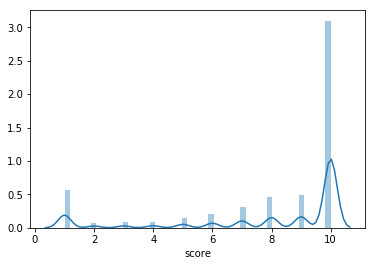

In [5]:
import seaborn as sns
%matplotlib inline
sns.distplot(data['score'])

영화, 배우 숫자

In [6]:
import re

In [7]:
re_movie = re.compile("mv[0-9]*")
re_actor = re.compile("ac[0-9]*")

In [8]:
data['movie'] = data['comment'].map(lambda x: re_movie.findall(x))
data['actor'] = data['comment'].map(lambda x: re_actor.findall(x))

In [9]:
movie_ids = list()
actor_ids = list()
for item in data['movie'].values:
    movie_ids += item
for item in data['actor'].values:
    actor_ids += item

In [10]:
from collections import Counter

In [12]:
data.head(2)

,comment,score,movie,actor
0,아련한 향수를 떠올리게 만드는 추억의 영화,8,[],[]
1,SF 코미디 영화사에서 가장 주목해야할 영화,9,[],[]


In [13]:
for item in data.values:
    if 'mv000' in item[2]:
        print(item[0])

넘 mv000mv002480624.. ㅋㅋㅋㅋ
mv000mv002586193 대충봤다
mv000mv000941748까잔 재밋다
ㅋㅋ mv000mv000941748 짱 재미있던데...
mv000mv000941748진짜재밋더라재미없으면보지말던가
mv000mv000941748 -100 : cgv -100
mv000mv000941748는독특한방법으로웃기고있다정말재밌다
정말좋았습니다 !!!! mv000mv000941748♡
mv000mv000941748 재밌습니다.
mv000mv000941748 제게 재밌네요
mv00067885랑 mv000mv000941748랑 다른게 머야?졸 재미없다
mv00067885에 두짜에 흠이 생겨서 mv000mv000941748
mv000mv000941748 상영관 반경 1km 이내 접근금지.
엄청 재밌어요 ! ㅎ mv000mv000941748 !♡
><mv000mv000941748재미잇엇어요^.^나중에또보고싶은영화ㅋㅋ
역시 mv000mv000941748!!실망시키지않음!
"왕의남자보고 울고, mv000mv000941748보고 웃었다. 약간감동"
mv000mv000941748 잼잇어요
mv000mv000941748 완전재밌구요 다시한번보고싶은영화네요ㅎ


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


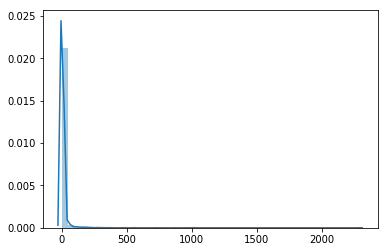

In [14]:
def foo(raw):
    return len(raw),

In [15]:
foo("안녕")

(2,)

In [16]:
class LengthFeatureExtractor:
    """A dummy feature extractor that counts the number of tokens"""
    
    def __init__(self, config):
        pass
    
    def fit(self, data):
        """
        Args:
            data : (raw_text, score)로 이루어진 list
        Returns:
            raise NotImplementedError if not implemented
        """
        raise NotImplementedError
    
    def extract_feature(self, raw_text, tokenized_text):
        """Count the number of tokens
        
        Args:
            raw_text: A string of raw text. For example: "무궁화 꽃이 피었습니다."
            tokenized_text: A list of tokens from raw text. For example: ['무궁화', '꽃이', '피었습니다.']
            
        Returns:
            A tuple that represents the counts of tokens.
        """
        
        counts = len(tokenized_text)
        return counts,  # make it a tuple

class BasicFeaturesExtractor:
    """
    Extracts basic features of raw text
    """
    def __init__(self, config):
        pass
    
    def fit(self, data):
        """
        Args:
            data : (raw_text, score)로 이루어진 list
        Returns:
            raise NotImplementedError if not implemented
        """
        raise NotImplementedError
    
    def extract_feature(self, raw_text, tokenized_text):
        """
        Returns:
            [0] raw text의 길이
            [1] token의 수
        """
        return len(raw_text), len(tokenized_text),

In [104]:
(0)*7

0

In [100]:
class ImportantWordFeaturesExtractor:
    """
    Extracts negative words, bad words, reverse words, specific words('ㅋ','ㅜ') 
    """
    def __init__(self):
        self.re_badwords = re.compile("시[0-9]*발")
    
    def fit(self, data):
        """
        Args:
            data : (raw_text, score)로 이루어진 list
        Returns:
            raise NotImplementedError if not implemented
        """
        raise NotImplementedError
    
    def extract_feature(self, raw_text, tokenized_text):
        """
        Count the number of bad words
        Returns:
            [0] 욕설 단어의 수
            [1] 부정적 단어의 수
            [2] 반전적 단어의 수
            [3] 'ㅋ' 단어의 수
            [4] 'ㅎ' 단어의 수
            [5] 'ㅜ' 단어의 수
            [6] 'ㅡ' 단어의 수
        """
        tokenized_words = set(tokenized_text)
        result = [0]*7
        negative_words = {'안', '못', '안봐', '안보', '안봤', '못보', '못잤', '못된', '안들', '안가', '안자', '안해'}
        reverse_words = {'지만', '러나', '근데', '허나'}
        
        result[0] = len(self.re_badwords.findall(raw_text))
        result[1] = len(negative_words & tokenized_words)
        result[2] = len(reverse_words & tokenized_words)
        result[3] = raw_text.count('ㅋ')
        result[4] = raw_text.count('ㅎ')
        result[5] = raw_text.count('ㅜ')
        result[6] = raw_text.count('ㅡ')
        
        return tuple(result)

In [80]:
import re
from collections import defaultdict, Counter
class MovieActorFeaturesExtractor:
    """
    Extracts statistics of movie and actor if mentioned
    """
    def __init__(self):
        re_movie = re.compile("mv[0-9]*")
        re_actor = re.compile("ac[0-9]*")
        self.movies_dict = None
        self.actors_dict = None
        self.global_stat = None
    
    def fit(self, data, threshold=20):
        """
        Extract global features of movies and actors
        Args:
            data : (raw_text, score)로 이루어진 list
            threshold : overfitting을 방지하기 위해 threshold이상 언급된 영화, 배우만 반영
        """
        movies_dict = defaultdict(lambda : list())
        actors_dict = defaultdict(lambda : list())
        for (comment, score) in data:
            for m_id in re_movie.findall(comment):
                movies_dict[m_id].append(score)
            for a_id in re_actor.findall(comment):
                actors_dict[a_id].append(score)
        movies_dict = {movie:l for movie,l in movies_dict.items() if len(l)>threshold}
        actors_dict = {actor:l for actor,l in actors_dict.items() if len(l)>threshold}
        self.movies_dict = movies_dict
        self.actors_dict = actors_dict
        self.global_stat = (np.mean([x[1] for x in data]), np.std([x[1] for x in data]))
                            
    def extract_feature(self, raw_text, tokenized_text):
        """
        Returns:
            [0] 언급된 영화의 평균 평점. 없을 시 전체 영화의 평균평점, 두 개 이상 시 평균
            [1] 언급된 영화 평점의 표준편차. 없을 시 전체 영화 평점의 표준편차, 두 개 이상 시 평균
            [2] 언급된 배우의 평균 평점. 없을 시 전체 배우의 평균평점, 두 개 이상 시 평균
            [3] 언급된 배우 평점의 표준편차. 없을 시 전체 배우 평점의 표준편차, 두 개 이상 시 평균
        """
        movies_dict = self.movies_dict
        actors_dict = self.actors_dict
        
        movie_scores = []
        for m_id in re_movie.findall(raw_text):
            if m_id in movies_dict:
                movie_scores.append((np.mean(movies_dict[m_id]), np.std(movies_dict[m_id])))
        
        actor_scores = []
        for a_id in re_actor.findall(raw_text):
            if a_id in actors_dict:
                actor_scores.append((np.mean(actors_dict[a_id]), np.std(actors_dict[a_id])))
        result = [self.global_stat[0], self.global_stat[1]]*2
        
        if len(movie_scores)!=0:
            result[0] = np.mean([x[0] for x in movie_scores])
            result[1] = np.mean([x[1] for x in movie_scores])
        if len(actor_scores)!=0:
            result[2] = np.mean([x[0] for x in actor_scores])
            result[3] = np.mean([x[1] for x in actor_scores])
        
        return result